In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import gensim
import keras
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

In [4]:
stop = list()
file = open('stopwords_pt.txt',encoding='utf-8')
for word in file.read().splitlines():
    stop.append(word)

In [5]:
data = pd.read_csv('OffComBR3.csv', sep=',')

In [6]:
data.head(10)

,target,tweet_text
0,1,Votaram no PEZAO Agora tomem no CZAO
1,0,cuidado com a poupanca pessoal Lembram o que a...
2,0,Sabe o que eu acho engracado os nossos governa...
3,0,Podiam retirar dos lucros dos bancos
4,0,CADE O GALVAO PRA NARRAR AGORA FALIIIIUUUUUU...
5,0,Nao e possivel que deputados tenham tantos car...
6,0,Sejam honestos aprovem o projeto original vamo...
7,0,Nao a pizza anunciada de anistia do caixa Sim...
8,0,quem ja viu bandidos fazendo leis contra antic...
9,0,Olha os caras fazendo algo de util e de intere...


C:\Users\luisa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Target values')

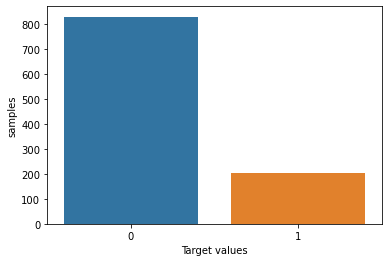

In [50]:
x=data.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')
plt.gca().set_xlabel('Target values')

In [44]:
data = data.sample(frac=1).reset_index(drop=True)

In [45]:
def create_corpus(data):
    corpus=[]
    for tweet in tqdm(data['tweet_text']):
        words=[word.lower() for word in word_tokenize(tweet, language='portuguese') if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

In [12]:
corpus=create_corpus(data)

100%|████████████████████████████████████████████████████████████████████████████| 1033/1033 [00:00<00:00, 3744.14it/s]


In [13]:
embeddings_index = {}
f = open('cbow_s100.txt',encoding='utf-8')
for line in tqdm(f):
   	values = line.strip().rsplit(' ')
   	word = values[0]
   	coefs = np.asarray(values[1:], dtype='float32')
   	embeddings_index[word] = coefs
f.close()

929606it [01:15, 12391.26it/s]


In [14]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [15]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 3619


In [16]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embeddings_index.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████████████████████████████████████████████████████████████████████| 3619/3619 [00:00<00:00, 157457.17it/s]


In [17]:
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           362000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 442,501
Trainable params: 80,501
Non-trainable params: 362,000
_________________________________________________________________


In [46]:
train,valid=train_test_split(data,test_size=0.30)
print('Shape of train',train.shape)
print("Shape of Validation ",valid.shape)

Shape of train (723, 2)
Shape of Validation  (310, 2)


In [39]:
X_train,y_train = tweet_pad[:750],data['target'][:750]
X_test,y_test= tweet_pad[750:],data['target'][750:]

In [40]:
history=model.fit(X_train,y_train,batch_size=8,epochs=10,validation_data=(X_test,y_test),verbose=2, shuffle=True)

Epoch 1/10
94/94 - 6s - loss: 0.2633 - accuracy: 0.9067 - val_loss: 0.9436 - val_accuracy: 0.6466
Epoch 2/10
94/94 - 6s - loss: 0.2789 - accuracy: 0.8973 - val_loss: 0.9235 - val_accuracy: 0.6466
Epoch 3/10
94/94 - 7s - loss: 0.2779 - accuracy: 0.9053 - val_loss: 0.9312 - val_accuracy: 0.6466
Epoch 4/10
94/94 - 10s - loss: 0.2706 - accuracy: 0.8987 - val_loss: 0.9331 - val_accuracy: 0.6466
Epoch 5/10
94/94 - 8s - loss: 0.2701 - accuracy: 0.9027 - val_loss: 0.9510 - val_accuracy: 0.6466
Epoch 6/10
94/94 - 9s - loss: 0.2815 - accuracy: 0.8987 - val_loss: 0.9331 - val_accuracy: 0.6502
Epoch 7/10
94/94 - 9s - loss: 0.2729 - accuracy: 0.8987 - val_loss: 0.9424 - val_accuracy: 0.6502
Epoch 8/10
94/94 - 8s - loss: 0.2756 - accuracy: 0.9133 - val_loss: 0.9414 - val_accuracy: 0.6466
Epoch 9/10
94/94 - 10s - loss: 0.2838 - accuracy: 0.9013 - val_loss: 0.9138 - val_accuracy: 0.6502
Epoch 10/10
94/94 - 7s - loss: 0.2800 - accuracy: 0.8920 - val_loss: 0.9186 - val_accuracy: 0.6466


In [42]:
y_pre=model.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(283)

In [43]:
print(roc_auc_score(y_pre,y_test))

0.7405893536121675


In [52]:
print(cohen_kappa_score(y_test, y_pre))

0.15172951261914758
